## Import library

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [2]:
anime_df = pd.read_csv('dataset/anime.csv')
rating_df = pd.read_csv('dataset/rating.csv')
print("Datasets loaded successfully!")
print(f"Shape of anime_df: {anime_df.shape}")
print(f"Shape of rating_df: {rating_df.shape}")

Datasets loaded successfully!
Shape of anime_df: (12294, 7)
Shape of rating_df: (7813737, 3)


## Data Understanding

In [3]:
print("\n--- Anime DataFrame Info ---")
anime_df.info()
print("\nFirst 5 rows of anime_df:")
print(anime_df.head())
print("\nMissing values in anime_df:")
print(anime_df.isnull().sum())
print("\nNumber of unique genres:")


--- Anime DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

First 5 rows of anime_df:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Super

Memisahkan genre dan menghitung genre yang unik

In [4]:
all_genres = anime_df['genre'].dropna().str.split(', ').explode().unique()
print(len(all_genres))
print("\nTop 10 most frequent anime types:")
print(anime_df['type'].value_counts().head(10))

43

Top 10 most frequent anime types:
type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: count, dtype: int64


Rating DataFrame Info

In [5]:
rating_df.info()
print("\nFirst 5 rows of rating_df:")
print(rating_df.head())
print("\nMissing values in rating_df:")
print(rating_df.isnull().sum())
print("\nDistribution of ratings (excluding -1):")
print(rating_df[rating_df['rating'] != -1]['rating'].value_counts().sort_index())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

First 5 rows of rating_df:
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

Missing values in rating_df:
user_id     0
anime_id    0
rating      0
dtype: int64

Distribution of ratings (excluding -1):
rating
1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: count, dtype: int64


Visualisasi distribusi rating

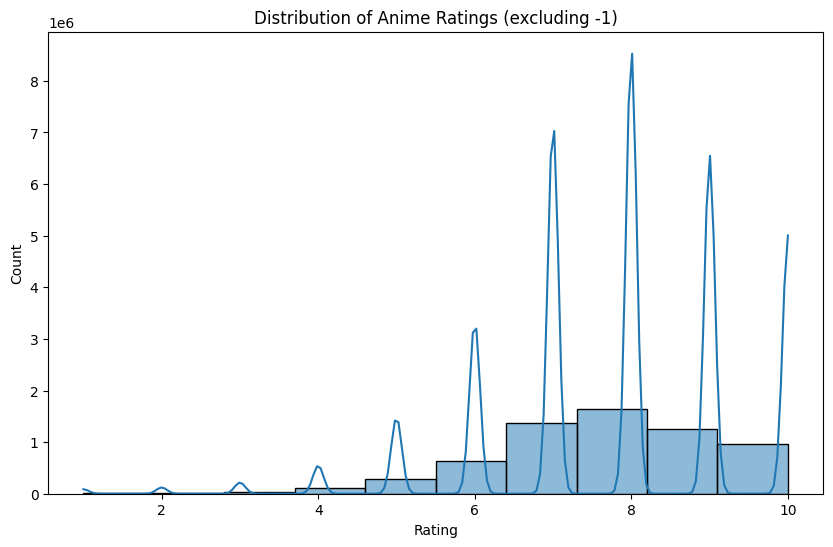

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(rating_df[rating_df['rating'] != -1]['rating'], bins=10, kde=True)
plt.title('Distribution of Anime Ratings (excluding -1)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Visualisasi top N genres

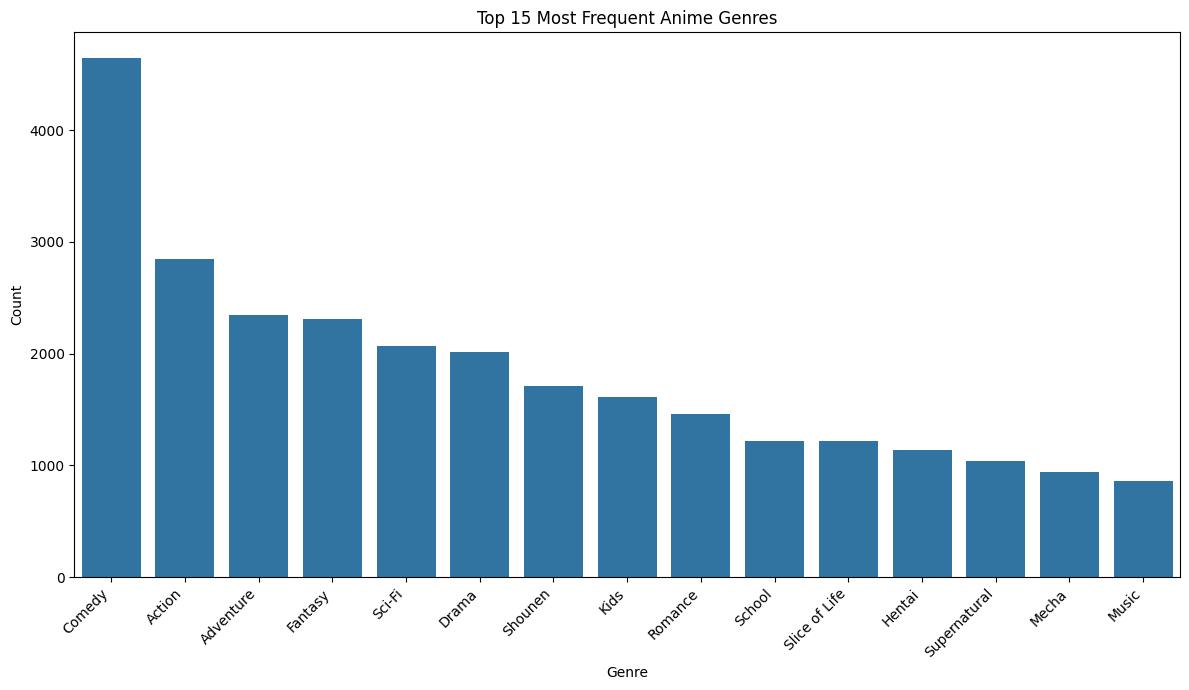

In [7]:
genre_counts = anime_df['genre'].dropna().str.split(', ').explode().value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.head(15).index, y=genre_counts.head(15).values)
plt.title('Top 15 Most Frequent Anime Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tinjauan Dataframe Gabungan (setelah inspeksi awal)

In [8]:
# Merge datasets early to check for potential issues with merging
initial_merged_df = pd.merge(rating_df, anime_df, on='anime_id', suffixes=('_user', '_anime'))
print(f"Shape of initial_merged_df: {initial_merged_df.shape}")
print("Initial Merged DataFrame Head:")
print(initial_merged_df.head())

Shape of initial_merged_df: (7813727, 9)
Initial Merged DataFrame Head:
   user_id  anime_id  rating_user                       name  \
0        1        20           -1                     Naruto   
1        1        24           -1              School Rumble   
2        1        79           -1                   Shuffle!   
3        1       226           -1                 Elfen Lied   
4        1       241           -1  Girls Bravo: First Season   

                                               genre type episodes  \
0  Action, Comedy, Martial Arts, Shounen, Super P...   TV      220   
1                   Comedy, Romance, School, Shounen   TV       26   
2  Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...   TV       24   
3  Action, Drama, Horror, Psychological, Romance,...   TV       13   
4     Comedy, Ecchi, Fantasy, Harem, Romance, School   TV       11   

   rating_anime  members  
0          7.81   683297  
1          8.06   178553  
2          7.31   158772  
3          7.8

## Data Preparation

Pra-pemrosesan DataFrame Anime

In [9]:
print("Menangani nilai yang hilang pada anime_df...")

Menangani nilai yang hilang pada anime_df...


Mengisi nilai 'genre' yang kosong dengan 'Tidak Diketahui'

In [10]:
anime_df['genre'] = anime_df['genre'].fillna('Unknown')

Mengisi nilai 'rating' (penilaian keseluruhan anime) yang kosong dengan rata-rata

In [11]:
anime_df['rating'] = anime_df['rating'].fillna(anime_df['rating'].mean())
print("Jumlah nilai yang hilang dalam anime_df setelah pengisian:")
print(anime_df.isnull().sum())

Jumlah nilai yang hilang dalam anime_df setelah pengisian:
anime_id     0
name         0
genre        0
type        25
episodes     0
rating       0
members      0
dtype: int64


Menghapus data duplikat berdasarkan 'anime_id' untuk memastikan setiap anime unik

In [12]:
initial_anime_rows = anime_df.shape[0]
anime_df.drop_duplicates(subset='anime_id', inplace=True)
print(f"Dropped {initial_anime_rows - anime_df.shape[0]} duplicate anime entries.")
print(f"Shape of anime_df after dropping duplicates: {anime_df.shape}")

Dropped 0 duplicate anime entries.
Shape of anime_df after dropping duplicates: (12294, 7)


Pra-pemrosesan DataFrame Rating

Menghapus rating -1: ini menunjukkan anime sudah ditonton tapi belum diberi nilai,

yang tidak berguna untuk prediksi rating eksplisit dalam collaborative filtering.

In [13]:
initial_rating_rows = rating_df.shape[0]
rating_df = rating_df[rating_df['rating'] != -1]
print(f"Removed {initial_rating_rows - rating_df.shape[0]} ratings of -1.")
print(f"Shape of rating_df after removing -1 ratings: {rating_df.shape}")

Removed 1476496 ratings of -1.
Shape of rating_df after removing -1 ratings: (6337241, 3)


Menggabungkan dataset

In [14]:
print("\nMerging anime and rating dataframes...")
merged_df = pd.merge(rating_df, anime_df, on='anime_id', suffixes=('_user', '_anime'))
print(f"Shape of merged_df after merging: {merged_df.shape}")
print("\nMerged DataFrame Head (after preprocessing):")
print(merged_df.head())


Merging anime and rating dataframes...
Shape of merged_df after merging: (6337239, 9)

Merged DataFrame Head (after preprocessing):
   user_id  anime_id  rating_user                    name  \
0        1      8074           10  Highschool of the Dead   
1        1     11617           10         High School DxD   
2        1     11757           10        Sword Art Online   
3        1     15451           10     High School DxD New   
4        2     11771           10        Kuroko no Basket   

                                               genre type episodes  \
0                Action, Ecchi, Horror, Supernatural   TV       12   
1      Comedy, Demons, Ecchi, Harem, Romance, School   TV       12   
2          Action, Adventure, Fantasy, Game, Romance   TV       25   
3  Action, Comedy, Demons, Ecchi, Harem, Romance,...   TV       12   
4                    Comedy, School, Shounen, Sports   TV       25   

   rating_anime  members  
0          7.46   535892  
1          7.70   398660 

Membersihkan kolom genre untuk TF-IDF (menghapus koma dan spasi berlebih)

In [15]:
anime_df['genre_cleaned'] = anime_df['genre'].apply(lambda x: ' '.join(x.replace(',', ' ').split()))
print("\n'genre_cleaned' column created for Content-based Filtering.")


'genre_cleaned' column created for Content-based Filtering.


## Modeling

Inisialisasi TF-IDF Vectorizer

stop_words='english' menghapus kata-kata umum bahasa Inggris yang kurang bermakna

In [16]:
tfidf = TfidfVectorizer(stop_words='english')

Melatih dan mentransformasikan kolom 'genre_cleaned' untuk membuat matriks TF-IDF

In [17]:
tfidf_matrix = tfidf.fit_transform(anime_df['genre_cleaned'])

In [18]:
print(f"Ukuran matriks TF-IDF: {tfidf_matrix.shape}")

Ukuran matriks TF-IDF: (12294, 47)


Menghitung matriks kemiripan kosinus

Matriks ini menunjukkan kemiripan antar anime berdasarkan vektor genre mereka

In [19]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Ukuran matriks Kemiripan Kosinus: {cosine_sim.shape}")

Ukuran matriks Kemiripan Kosinus: (12294, 12294)


Membuat Series yang memetakan nama anime ke indeksnya di dataframe

Ini memudahkan pencarian indeks anime berdasarkan namanya

In [20]:
indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()


Fungsi untuk mendapatkan rekomendasi berbasis konten 

Mendapatkan indeks anime yang sesuai dengan judul

Mendapatkan skor kemiripan pasangan semua anime dengan anime tersebut

Mengurutkan anime berdasarkan skor kemiripan

Mendapatkan skor untuk top N anime yang paling mirip (tidak termasuk dirinya sendiri)


In [21]:
def get_content_recommendations(title, cosine_sim_matrix=cosine_sim, df=anime_df, indices_series=indices, top_n=10):
    """
    Generates content-based recommendations for a given anime title.

    Args:
        title (str): The name of the anime to get recommendations for.
        cosine_sim_matrix (np.array): The cosine similarity matrix of anime.
        df (pd.DataFrame): The anime dataframe.
        indices_series (pd.Series): A Series mapping anime names to their indices.
        top_n (int): The number of top recommendations to return.

    Returns:
        pd.DataFrame: A DataFrame containing the recommended anime details and similarity scores.
    """
    if title not in indices_series:
        print(f"Anime '{title}' not found in the database. Please check the spelling.")
        return pd.DataFrame() 


    idx = indices_series[title]
    
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:top_n+1] 

    anime_indices = [i[0] for i in sim_scores]

    recommendations = df.iloc[anime_indices][['name', 'genre', 'type', 'rating']].copy()
    recommendations['similarity_score'] = [i[1] for i in sim_scores]

    return recommendations

Contoh Rekomendasi Berbasis Konten

In [22]:
print("\nExample Content-based Recommendations for 'Death Note':")
content_recs = get_content_recommendations('Death Note')
if not content_recs.empty:
    print(content_recs)



Example Content-based Recommendations for 'Death Note':
                                          name  \
778                         Death Note Rewrite   
981                            Mousou Dairinin   
144              Higurashi no Naku Koro ni Kai   
1383             Higurashi no Naku Koro ni Rei   
445                           Mirai Nikki (TV)   
4164         Mirai Nikki (TV): Ura Mirai Nikki   
334                  Higurashi no Naku Koro ni   
38                                     Monster   
5382                                 AD Police   
2074  Higurashi no Naku Koro ni Kaku: Outbreak   

                                                  genre     type  rating  \
778   Mystery, Police, Psychological, Supernatural, ...  Special    7.84   
981   Drama, Mystery, Police, Psychological, Superna...       TV    7.74   
144      Mystery, Psychological, Supernatural, Thriller       TV    8.41   
1383  Comedy, Mystery, Psychological, Supernatural, ...      OVA    7.56   
445   Action

In [23]:
print("\nExample Content-based Recommendations for 'Naruto':")
content_recs_naruto = get_content_recommendations('Naruto')
if not content_recs_naruto.empty:
    print(content_recs_naruto)


Example Content-based Recommendations for 'Naruto':
                                                   name  \
615                                  Naruto: Shippuuden   
841                                              Naruto   
1103  Boruto: Naruto the Movie - Naruto ga Hokage ni...   
1343                                        Naruto x UT   
1472        Naruto: Shippuuden Movie 4 - The Lost Tower   
1573  Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...   
2458               Naruto Shippuuden: Sunny Side Battle   
2997  Naruto Soyokazeden Movie: Naruto to Mashin to ...   
7628                            Kyutai Panic Adventure!   
784          Naruto: Shippuuden Movie 6 - Road to Ninja   

                                                  genre     type  rating  \
615   Action, Comedy, Martial Arts, Shounen, Super P...       TV    7.94   
841   Action, Comedy, Martial Arts, Shounen, Super P...       TV    7.81   
1103  Action, Comedy, Martial Arts, Shounen, Super P...  Special    7

## Collaborative Filtering

Pendekatan ini merekomendasikan anime berdasarkan perilaku pengguna lain yang memiliki preferensi serupa. Kita akan menggunakan library Surprise dan algoritma Singular Value Decomposition (SVD) untuk memprediksi rating yang belum diberikan.

 Pemodelan (lanjutan) - Collaborative Filtering 

Persiapkan data untuk library Surprise

Objek Reader mendefinisikan skala rating (1 sampai 10 di dataset ini)


In [24]:
reader = Reader(rating_scale=(1, 10))

Muat data ke format Dataset Surprise dari merged_df

Kita hanya butuh user_id, anime_id, dan rating untuk collaborative filtering

In [25]:
data = Dataset.load_from_df(merged_df[['user_id', 'anime_id', 'rating_user']], reader)

Bangun trainset dari seluruh data untuk melatih model akhir Untuk evaluasi biasanya kita pisah train/test, tapi untuk prediksi ke semua userkita bisa latih dengan seluruh data.

Atau untuk evaluasi cross-validation, kita bisa gunakan `cross_validate` nanti.

In [ ]:
trainset = data.build_full_trainset()

Gunakan algoritma SVD (Singular Value Decomposition)

SVD adalah teknik faktorisasi matriks yang sering dipakai di collaborative filtering

In [27]:
algo = SVD(random_state=42)

Latih model menggunakan seluruh trainset

In [28]:
print("Melatih model SVD untuk Collaborative Filtering...")
algo.fit(trainset)
print("Model SVD berhasil dilatih!")

Melatih model SVD untuk Collaborative Filtering...
Model SVD berhasil dilatih!


Fungsi get_collaborative_recommendations ini digunakan untuk menghasilkan rekomendasi anime bagi seorang pengguna tertentu dengan menggunakan metode collaborative filtering berbasis model SVD yang sudah dilatih; fungsi ini pertama-tama mengambil semua anime yang tersedia dan menghapus anime yang sudah pernah dirating oleh pengguna tersebut agar hanya merekomendasikan anime baru, kemudian memprediksi rating estimasi untuk setiap anime yang belum dirating oleh pengguna tersebut menggunakan model SVD, mengurutkan anime berdasarkan prediksi rating tertinggi, dan mengembalikan DataFrame yang berisi detail anime teratas beserta prediksi rating khusus untuk pengguna tersebut.

In [29]:
def get_collaborative_recommendations(user_id, num_recommendations=10, df_anime=anime_df, df_merged=merged_df, svd_model=algo):
    """
    Menghasilkan rekomendasi collaborative filtering untuk user tertentu.

    Argumen:
        user_id (int): ID user yang ingin direkomendasikan.
        num_recommendations (int): Jumlah rekomendasi teratas yang dikembalikan.
        df_anime (pd.DataFrame): Dataframe anime.
        df_merged (pd.DataFrame): Dataframe gabungan rating dan info anime.
        svd_model: Model SVD yang sudah dilatih.

    Mengembalikan:
        pd.DataFrame: DataFrame berisi detail anime rekomendasi dan prediksi rating.
    """

    all_anime_ids = df_anime['anime_id'].unique()

    rated_anime_ids = df_merged[df_merged['user_id'] == user_id]['anime_id'].unique()

    anime_to_predict = [anime_id for anime_id in all_anime_ids if anime_id not in rated_anime_ids]

    predictions = []
    for anime_id in anime_to_predict:
        pred = svd_model.predict(uid=user_id, iid=anime_id)
        predictions.append((anime_id, pred.est))
    predictions.sort(key=lambda x: x[1], reverse=True)

    top_anime_ids = [x[0] for x in predictions[:num_recommendations]]
    top_estimated_ratings = [x[1] for x in predictions[:num_recommendations]]

    recommended_anime_details = df_anime[df_anime['anime_id'].isin(top_anime_ids)][['anime_id', 'name', 'genre', 'type', 'rating']].copy()

    final_recommendations = []
    for i, anime_id in enumerate(top_anime_ids):
        anime_info = recommended_anime_details[recommended_anime_details['anime_id'] == anime_id].iloc[0]
        final_recommendations.append({
            'anime_id': anime_info['anime_id'],
            'name': anime_info['name'],
            'genre': anime_info['genre'],
            'type': anime_info['type'],
            'average_anime_rating': anime_info['rating'],
            'predicted_rating_for_user': top_estimated_ratings[i]
        })
    return pd.DataFrame(final_recommendations)

Contoh rekomendasi Collaborative Filtering untuk seorang user

Cari user_id yang ada di dataset (misal user yang sudah memberi rating anime)

Supaya pasti dapat user yang sudah punya rating, kita filter merged_df

In [30]:
users_with_ratings = merged_df['user_id'].unique()
if len(users_with_ratings) > 0:
    example_user_id = np.random.choice(users_with_ratings)
else:
    example_user_id = 1

print(f"\nContoh Rekomendasi Collaborative Filtering untuk user_id: {example_user_id}:")
cf_recs = get_collaborative_recommendations(example_user_id)
print(cf_recs)


Contoh Rekomendasi Collaborative Filtering untuk user_id: 64751:
   anime_id                                               name  \
0       820                               Ginga Eiyuu Densetsu   
1     32281                                     Kimi no Na wa.   
2     30276                                      One Punch Man   
3        19                                            Monster   
4     32935  Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...   
5      9253                                        Steins;Gate   
6       877                                               Nana   
7     28977                                           Gintama°   
8       338                                 Rose of Versailles   
9      5114                   Fullmetal Alchemist: Brotherhood   

                                               genre   type  \
0                     Drama, Military, Sci-Fi, Space    OVA   
1               Drama, Romance, School, Supernatural  Movie   
2  Action, Comedy,

Untuk melihat anime apa saja yang sudah dirating user tersebut:

In [31]:
print(f"\nAnime rated by user_id {example_user_id}:")
user_rated_anime = merged_df[merged_df['user_id'] == example_user_id][['name', 'rating_user', 'genre']].sort_values(by='rating_user', ascending=False)
print(user_rated_anime.head(10))


Anime rated by user_id 64751:
                    name  rating_user  \
5636833  No Game No Life            8   

                                                     genre  
5636833  Adventure, Comedy, Ecchi, Fantasy, Game, Super...  


##  Evaluation

Lakukan cross-validation 5-fold untuk mengukur performa model SVD

In [32]:
print("Melakukan cross-validation 5-fold untuk model SVD...")
cross_validation_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Melakukan cross-validation 5-fold untuk model SVD...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1338  1.1332  1.1322  1.1336  1.1336  1.1333  0.0006  
MAE (testset)     0.8450  0.8450  0.8436  0.8451  0.8451  0.8448  0.0006  
Fit time          62.52   62.79   58.79   58.70   58.65   60.29   1.93    
Test time         16.23   12.48   13.31   11.96   13.22   13.44   1.48    


RMSE (Root Mean Squared Error): Mengukur besarnya rata-rata kesalahan.

RMSE yang lebih rendah menunjukkan akurasi yang lebih baik dalam memprediksi peringkat.

In [33]:
print(f"Mean RMSE: {cross_validation_results['test_rmse'].mean():.4f}")
print(f"Standard Deviation of RMSE: {cross_validation_results['test_rmse'].std():.4f}")

Mean RMSE: 1.1333
Standard Deviation of RMSE: 0.0006


MAE (Mean Absolute Error): Mengukur rata-rata perbedaan absolut antara peringkat yang diprediksi dan aktual.

Mirip dengan RMSE, MAE yang lebih rendah menunjukkan akurasi yang lebih tinggi.

In [34]:
print(f"Mean MAE: {cross_validation_results['test_mae'].mean():.4f}")
print(f"Standard Deviation of MAE: {cross_validation_results['test_mae'].std():.4f}")

Mean MAE: 0.8448
Standard Deviation of MAE: 0.0006


Tampilkan kembali contoh untuk penilaian kualitatif

In [35]:
content_recs_eval = get_content_recommendations('Death Note')
if not content_recs_eval.empty:
    print(content_recs_eval)
    print("\nObservation: The recommendations for 'Death Note' (a psychological thriller) tend to be other anime with 'Thriller' or 'Mystery' genres, which indicates good content similarity.")

print("\n--- Conclusion of Evaluation ---")
print("The SVD model for Collaborative Filtering shows a reasonable RMSE, indicating good predictive accuracy for user ratings.")
print("Content-based filtering provides recommendations based on clear genre similarity, which is intuitively logical.")

                                          name  \
778                         Death Note Rewrite   
981                            Mousou Dairinin   
144              Higurashi no Naku Koro ni Kai   
1383             Higurashi no Naku Koro ni Rei   
445                           Mirai Nikki (TV)   
4164         Mirai Nikki (TV): Ura Mirai Nikki   
334                  Higurashi no Naku Koro ni   
38                                     Monster   
5382                                 AD Police   
2074  Higurashi no Naku Koro ni Kaku: Outbreak   

                                                  genre     type  rating  \
778   Mystery, Police, Psychological, Supernatural, ...  Special    7.84   
981   Drama, Mystery, Police, Psychological, Superna...       TV    7.74   
144      Mystery, Psychological, Supernatural, Thriller       TV    8.41   
1383  Comedy, Mystery, Psychological, Supernatural, ...      OVA    7.56   
445   Action, Mystery, Psychological, Shounen, Super...       TV    8